# Modeling Preparation

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn import tree
from sklearn.svm import SVC  
from sklearn import svm

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.metrics import plot_confusion_matrix

In [2]:
# import dataset
df = pd.read_csv('..\\data\\telecom_data.csv')

# Handle object types for international plan and voice mail plan
df.loc[df['international plan'] == 'no', 'international plan'] = 0
df.loc[df['international plan'] == 'yes', 'international plan'] = 1 

df.loc[df['voice mail plan'] == 'no', 'voice mail plan'] = 0
df.loc[df['voice mail plan']== 'yes', 'voice mail plan'] = 1

# Change churn to values: 1 (churned/True) 0 (no churn/False)
df.loc[df['churn'] == True, 'churn'] = 1
df.loc[df['churn'] == False, 'churn'] = 0

# going to create backup df and drop phone number from original df
# phone number could be used as unique id, but it doesn't seem necessary
df_backup = df.copy()
df = df.drop(['phone number'], axis=1)

# casting int values to churn, voice mail plan, and international plan cols
objs = ['international plan', 'voice mail plan', 'churn']

for o in objs:
    df = df.astype({o: int})
    
# dropping area code
df = df.drop(['area code'], axis=1)

# check df
df.head()

,state,account length,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,OH,107,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,NJ,137,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,OH,84,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,OK,75,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


Handle international calls to bin them into categories easier.

In [3]:
# handle international calls to bin them into categories easier.
df['total intl calls'].value_counts()

3     668
4     619
2     489
5     472
6     336
7     218
1     160
8     116
9     109
10     50
11     28
0      18
12     15
13     14
15      7
14      6
18      3
16      2
19      1
17      1
20      1
Name: total intl calls, dtype: int64

{'whiskers': [<matplotlib.lines.Line2D at 0x18805978430>,
 'caps': [<matplotlib.lines.Line2D at 0x18805978af0>,
 'boxes': [<matplotlib.lines.Line2D at 0x188059780d0>],
 'medians': [<matplotlib.lines.Line2D at 0x188059c71f0>],
 'fliers': [<matplotlib.lines.Line2D at 0x188059c7550>],
 'means': []}

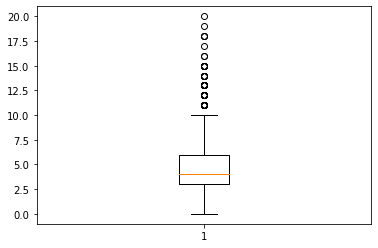

In [4]:
plt.boxplot(df['total intl calls'])

In [5]:
df['total intl calls'].describe()

count    3333.000000
mean        4.479448
std         2.461214
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max        20.000000
Name: total intl calls, dtype: float64

In [6]:
# range is 0-20 for international calls with most concentrated from 0-10
# I will bin into cats: low, moderate, and high with values <3, 3-6, and >6

list_tmp = []

for index, row in df.iterrows():
    if row['total intl calls'] < 3:
        list_tmp.append('low')
    elif row['total intl calls'] > 6:
        list_tmp.append('high')
    else:
        list_tmp.append('moderate')

df['total_intl_calls'] = list_tmp

df['total_intl_calls'].describe()

count         3333
unique           3
top       moderate
freq          2095
Name: total_intl_calls, dtype: object

## What would be the % chance of guessing correctly if the customer was assumed to not churn?

In [7]:
1-df.churn.mean()

0.8550855085508551

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   international plan      3333 non-null   int32  
 3   voice mail plan         3333 non-null   int32  
 4   number vmail messages   3333 non-null   int64  
 5   total day minutes       3333 non-null   float64
 6   total day calls         3333 non-null   int64  
 7   total day charge        3333 non-null   float64
 8   total eve minutes       3333 non-null   float64
 9   total eve calls         3333 non-null   int64  
 10  total eve charge        3333 non-null   float64
 11  total night minutes     3333 non-null   float64
 12  total night calls       3333 non-null   int64  
 13  total night charge      3333 non-null   float64
 14  total intl minutes      3333 non-null   

## Handle datatypes

Handle state and total_intl_calls object types. Turn these into integers for later modeling.

In [9]:
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA",
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", "MA",
          "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", "NM", "NY",
          "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", "SD", "TN", "TX",
          "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

In [10]:
state_int = []
for i, row in df.iterrows():
    state_int.append(states.index(row['state']))

In [11]:
df['state_int'] = state_int

In [12]:
intl_calls_int = []
for i, row in df.iterrows():
    if row['total_intl_calls'] == 'low':
        intl_calls_int.append(0)
    elif row['total_intl_calls'] == 'moderate':
        intl_calls_int.append(1)
    else:
        intl_calls_int.append(2)

df['intl_calls_bins'] = intl_calls_int

In [13]:
cats = ['state_int', 'international plan', 'intl_calls_bins',
        'customer service calls', 'voice mail plan']

## Feature Engineering: Totals for Charge, Minutes, and Calls

In [14]:
df['total_calls'] = df.apply(lambda x: x['total night calls'] + x['total day calls'] + x['total night calls'], 
                               axis=1)
df['total_charge']= df.apply(lambda x: x['total day charge'] + x['total eve charge'] + x['total night charge'],
                                             axis=1)
df['total_minutes'] = df.apply(lambda x: x['total day minutes'] + x['total eve minutes'] + x['total night minutes'],
                                             axis=1)

## Define X and y and Normalize the Data

In [150]:
X_cats_ohe

,0,1,2,3,4,5,6,7,8,9,...,2,3,4,5,6,7,8,9,0,1
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3329,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3330,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3331,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [154]:
y = df['churn']
# dropping # vmail messages because its distribution isn't normal
# drop redundancies now that there are total charge, minutes, and calls cols.
X_tmp = df.drop(['churn', 'total intl calls', 'number vmail messages',
             'total_intl_calls', 'state', 'total day minutes',
             'total day calls', 'total day charge', 'total eve minutes',
             'total eve calls', 'total eve charge', 'total night minutes',
             'total night calls', 'total night charge'], axis=1)

X_cats = X_tmp[cats]

# handle categorical values
ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

ohe.fit(X_cats)
X_cats_ohe = pd.DataFrame(
    ohe.transform(X_cats),
    index=X_cats.index,
    columns=ohe.get_feature_names()
)

# Scaling variables to work well with OHE data
X_numerics = X_tmp.drop(cats, axis=1)

scaler = MinMaxScaler()

scaler.fit(X_numerics)
X_scaled = pd.DataFrame(
    scaler.transform(X_numerics),
    index=X_numerics.index,
    columns=X_numerics.columns
)

X = pd.concat([X_scaled, X_cats_ohe], axis=1)
X.head()

,account length,total intl minutes,total intl charge,total_calls,total_charge,total_minutes,x0_0,x0_1,x0_2,x0_3,...,x3_2,x3_3,x3_4,x3_5,x3_6,x3_7,x3_8,x3_9,x4_0,x4_1
0,0.524793,0.500,0.500000,0.448052,0.728575,0.717966,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.438017,0.685,0.685185,0.568182,0.489942,0.558916,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.561983,0.610,0.609259,0.545455,0.537614,0.418813,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.342975,0.330,0.329630,0.308442,0.620557,0.470334,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.305785,0.505,0.505556,0.652597,0.404795,0.376766,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Train-test-split and SMOTE

In [156]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Fixing class imbalance with SMOTE
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train)

## Confusion Matrix Helper Function

In [161]:
def conf_matrix(y_true, y_pred):
    cm = {'TP': 0, 'TN': 0, 'FP': 0, 'FN': 0}
    
    for ind, label in enumerate(y_true):
        pred = y_pred[ind]
        if label == 1:
            # CASE: TP 
            if label == pred:
                cm['TP'] += 1
            # CASE: FN
            else:
                cm['FN'] += 1
        else:
            # CASE: TN
            if label == pred:
                cm['TN'] += 1
            # CASE: FP
            else:
                cm['FP'] += 1
    return cm

# Baseline Model - Logistic Regression

## Fit data to model

In [157]:
# model
logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear',
                            random_state=1)
model_log = logreg.fit(X_train_resampled, y_train_resampled)
model_log

LogisticRegression(C=1000000000000.0, fit_intercept=False, random_state=1,
                   solver='liblinear')

## Evaluate

In [158]:
y_hat_train = logreg.predict(X_train_resampled)

train_residuals = np.abs(y_train_resampled - y_hat_train)
print(pd.Series(train_residuals, name="Residuals (counts)").value_counts())
print()
print(pd.Series(train_residuals, name="Residuals (proportions)").value_counts(normalize=True))

0    3655
1     627
Name: Residuals (counts), dtype: int64

0    0.853573
1    0.146427
Name: Residuals (proportions), dtype: float64


In [159]:
print(confusion_matrix(y_train_resampled, y_hat_train))  
print(classification_report(y_train_resampled, y_hat_train)) 
print("The accuracy score is" + " "+ str(accuracy_score(y_train_resampled, y_hat_train)))

[[1813  328]
 [ 299 1842]]
              precision    recall  f1-score   support

           0       0.86      0.85      0.85      2141
           1       0.85      0.86      0.85      2141

    accuracy                           0.85      4282
   macro avg       0.85      0.85      0.85      4282
weighted avg       0.85      0.85      0.85      4282

The accuracy score is 0.8535730966837927


In [160]:
y_hat_test = logreg.predict(X_test)

test_residuals = np.abs(y_test - y_hat_test)
print(pd.Series(test_residuals, name="Residuals (counts)").value_counts())
print()
print(pd.Series(test_residuals, name="Residuals (proportions)").value_counts(normalize=True))

print(confusion_matrix(y_test, y_hat_test))  
print(classification_report(y_test, y_hat_test)) 
print("The accuracy score is" + " "+ str(accuracy_score(y_test, y_hat_test)))

0    700
1    134
Name: Residuals (counts), dtype: int64

0    0.839329
1    0.160671
Name: Residuals (proportions), dtype: float64
[[602 107]
 [ 27  98]]
              precision    recall  f1-score   support

           0       0.96      0.85      0.90       709
           1       0.48      0.78      0.59       125

    accuracy                           0.84       834
   macro avg       0.72      0.82      0.75       834
weighted avg       0.89      0.84      0.85       834

The accuracy score is 0.8393285371702638


In [165]:
conf_matrix(y_test, y_hat_test)

{'TP': 98, 'TN': 602, 'FP': 107, 'FN': 27}

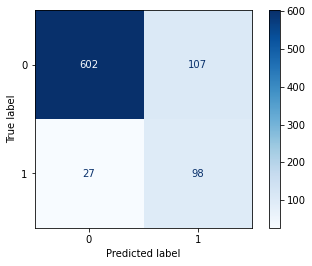

In [164]:
plot_confusion_matrix(logreg, X_test, y_test,
                     cmap=plt.cm.Blues)
plt.show()

Logistic Regression results:
* Accuracy is about 84% for test set and 85% for the train set.
* Both accuracy scores are below a random-guess strategy.
* 602 customers were correctly identified as retained (not churning), 98 were correctly identified as churning, 27 were falsely identified as retained, and 107 were falsely identified as churning.
* It will be key to reduce the number of customers that are identified as retained but actually churned. Ideally everyone that can be identified as churning will be retained with some kind of strategy.

# Model 2 - SVM

In [208]:
svclassifier = SVC(kernel='poly', C=1)  
svclassifier.fit(X_train_resampled, y_train_resampled) 
y_pred = svclassifier.predict(X_test)

In [209]:
print(confusion_matrix(y_test, y_pred))  
print(classification_report(y_test, y_pred)) 
print("The accuracy score is" + " "+ str(accuracy_score(y_test, y_pred)))

[[651  58]
 [ 30  95]]
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       709
           1       0.62      0.76      0.68       125

    accuracy                           0.89       834
   macro avg       0.79      0.84      0.81       834
weighted avg       0.91      0.89      0.90       834

The accuracy score is 0.894484412470024


Optimize parameters to use in SVM

In [210]:
def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='poly'), param_grid, cv=nfolds)
    grid_search.fit(X_train_resampled, y_train_resampled)
    grid_search.best_params_
    return grid_search.best_params_

In [211]:
svc_param_selection(X_train_resampled, y_train_resampled, 5)

{'C': 1, 'gamma': 1}

In [212]:
# best rbf params: C=10, gamma=1 with .861 accuracy on test set
# best poly params: C=1, gamma=1 with .887 accuracy on test set
svclassifier = SVC(kernel='poly', C=10, gamma=1)  
svclassifier.fit(X_train_resampled, y_train_resampled) 
y_pred = svclassifier.predict(X_test)

In [213]:
print(confusion_matrix(y_test, y_pred))  
print(classification_report(y_test, y_pred)) 
print("The accuracy score is" + " "+ str(accuracy_score(y_test, y_pred)))

[[656  53]
 [ 57  68]]
              precision    recall  f1-score   support

           0       0.92      0.93      0.92       709
           1       0.56      0.54      0.55       125

    accuracy                           0.87       834
   macro avg       0.74      0.73      0.74       834
weighted avg       0.87      0.87      0.87       834

The accuracy score is 0.86810551558753


In [214]:
y_pred_train = svclassifier.predict(X_train_resampled)
accuracy_score(y_train_resampled, y_pred_train)

0.9997664642690332

In [215]:
print(confusion_matrix(y_train_resampled, y_pred_train))  
print(classification_report(y_train_resampled, y_pred_train))

[[2140    1]
 [   0 2141]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2141
           1       1.00      1.00      1.00      2141

    accuracy                           1.00      4282
   macro avg       1.00      1.00      1.00      4282
weighted avg       1.00      1.00      1.00      4282



The accuracy score on the train set is about 12% higher than the test set, which suggests overfitting.

# Model 3 - RF

## Fit model

In [166]:
# random forest model
forest = RandomForestClassifier(n_estimators=100, max_depth=13, random_state=1)
forest.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(max_depth=13, random_state=1)

## Evaluate

In [169]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,16))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

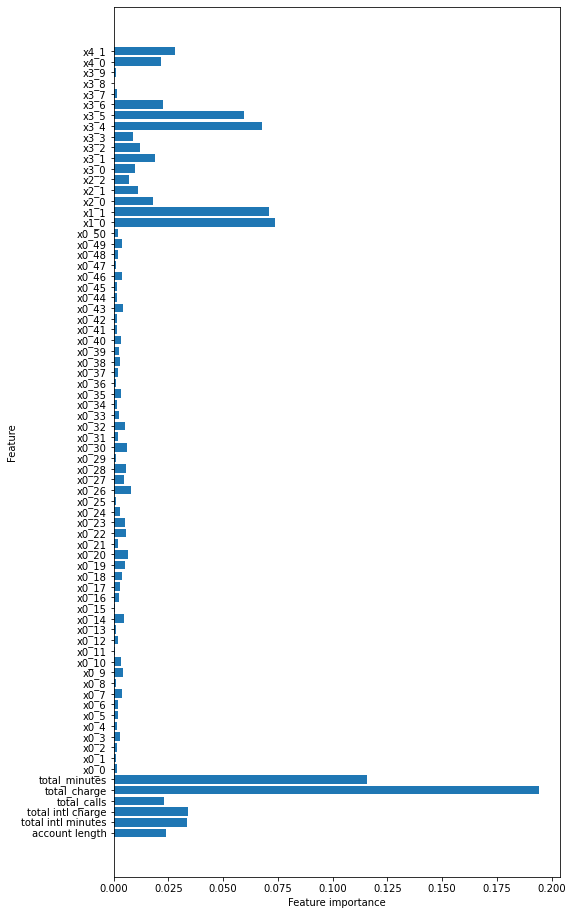

In [170]:
plot_feature_importances(forest)

In [167]:
# Training Accuracy
forest.score(X_train_resampled, y_train_resampled)

0.9635684259691732

In [168]:
# Testing Accuracy
forest.score(X_test, y_test)

0.9628297362110312

In [176]:
y_hat_train = forest.predict(X_train_resampled)

train_residuals = np.abs(y_train_resampled - y_hat_train)
print(pd.Series(train_residuals, name="Residuals (counts)").value_counts())
print()
print(pd.Series(train_residuals, name="Residuals (proportions)").value_counts(normalize=True))

print(confusion_matrix(y_train_resampled, y_hat_train))  
print(classification_report(y_train_resampled, y_hat_train)) 
print("The accuracy score is" + " "+ str(accuracy_score(y_train_resampled, y_hat_train)))

0    4126
1     156
Name: Residuals (counts), dtype: int64

0    0.963568
1    0.036432
Name: Residuals (proportions), dtype: float64
[[2139    2]
 [ 154 1987]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      2141
           1       1.00      0.93      0.96      2141

    accuracy                           0.96      4282
   macro avg       0.97      0.96      0.96      4282
weighted avg       0.97      0.96      0.96      4282

The accuracy score is 0.9635684259691732


In [175]:
y_hat_test = forest.predict(X_test)

test_residuals = np.abs(y_test - y_hat_test)
print(pd.Series(test_residuals, name="Residuals (counts)").value_counts())
print()
print(pd.Series(test_residuals, name="Residuals (proportions)").value_counts(normalize=True))

print(confusion_matrix(y_test, y_hat_test))  
print(classification_report(y_test, y_hat_test)) 
print("The accuracy score is" + " "+ str(accuracy_score(y_test, y_hat_test)))

0    803
1     31
Name: Residuals (counts), dtype: int64

0    0.96283
1    0.03717
Name: Residuals (proportions), dtype: float64
[[695  14]
 [ 17 108]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       709
           1       0.89      0.86      0.87       125

    accuracy                           0.96       834
   macro avg       0.93      0.92      0.93       834
weighted avg       0.96      0.96      0.96       834

The accuracy score is 0.9628297362110312


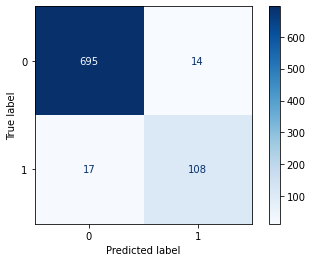

In [173]:
plot_confusion_matrix(forest, X_test, y_test,
                     cmap=plt.cm.Blues)
plt.show()

* The RF model performed really well! The false indications for retained customers is dramatically smaller than the baseline model.
* The model's accuracy is high, and there are not strong indications of overfitting.

# Model 4 - Optimize RF Model

## Fit and use GridSearchCV to find best parameters

In [199]:
# Using a pipeline to select for optimal parameters in the RF Classifier
pipe = Pipeline([('clf', RandomForestClassifier(random_state=1))])

grid_params = [{'clf__n_estimators': [100, 1000],
                'clf__criterion': ['gini', 'entropy'],
                'clf__max_depth': [None, 1, 5, 7, 11, 13, 17, 19],
                'clf__min_samples_split': [2, 5, 10],
                'clf__min_samples_leaf': [2, 3, 4, 5]
               }]

# grid search
gs = GridSearchCV(estimator=pipe,
                  param_grid=grid_params,
                  scoring='accuracy',
                  cv=10)

# Fit using grid search
gs.fit(X_train_resampled, y_train_resampled)

# Best accuracy
print('Best accuracy: %.3f' % gs.best_score_)

# Best params
print('\nBest params:\n', gs.best_params_)

Best accuracy: 0.957

Best params:
 {'clf__criterion': 'entropy', 'clf__max_depth': None, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 5, 'clf__n_estimators': 100}


This code took my machine about 1.5 hours to run.

In [203]:
forest = RandomForestClassifier(n_estimators=100, criterion='entropy', 
                                max_depth=None, min_samples_leaf=2,
                                min_samples_split=5, random_state=1)
forest.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(criterion='entropy', min_samples_leaf=2,
                       min_samples_split=5, random_state=1)

In [204]:
# Training Accuracy
forest.score(X_train_resampled, y_train_resampled)

0.9915927136851939

In [205]:
# Testing Accuracy
forest.score(X_test, y_test)

0.9712230215827338

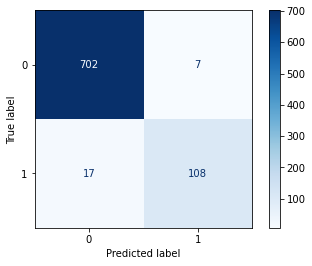

In [207]:
plot_confusion_matrix(forest, X_test, y_test,
                     cmap=plt.cm.Blues)
plt.show()

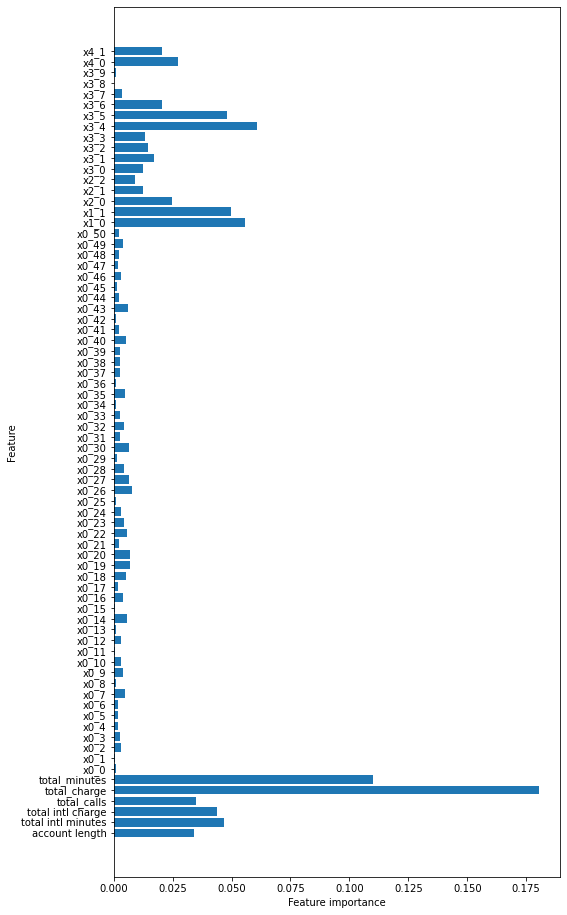

In [206]:
plot_feature_importances(forest)

# Model 5 - Optimize RF Model (2nd Attempt)

To avoid overfitting in the RF Model, the following strategies will be utilized:
* Use less features (use something like 50% of total features for the max features parameter).
* Keep n_estimators large because the more trees there are, the less likely it is to overfit.

In [221]:
# Using a pipeline to select for optimal parameters in the RF Classifier
pipe = Pipeline([('clf', RandomForestClassifier(random_state=1))])

grid_params = [{'clf__n_estimators': [100],
                'clf__criterion': ['entropy'],
                'clf__max_depth': [None, 1, 7, 15],
                'clf__min_samples_split': [2, 5, 10],
                'clf__min_samples_leaf': [2, 3, 4, 5],
                'clf__max_features': [37]     #this is 50% of total features
               }]

# grid search
gs = GridSearchCV(estimator=pipe,
                  param_grid=grid_params,
                  scoring='accuracy',
                  cv=10)

# Fit using grid search
gs.fit(X_train_resampled, y_train_resampled)

# Best accuracy
print('Best accuracy: %.3f' % gs.best_score_)

# Best params
print('\nBest params:\n', gs.best_params_)

Best accuracy: 0.956

Best params:
 {'clf__criterion': 'entropy', 'clf__max_depth': None, 'clf__max_features': 37, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 5, 'clf__n_estimators': 100}


In [222]:
forest = RandomForestClassifier(n_estimators=100, criterion='entropy', 
                                max_depth=None, min_samples_leaf=2,
                                min_samples_split=5, random_state=1,
                                max_features=37)
forest.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(criterion='entropy', max_features=37, min_samples_leaf=2,
                       min_samples_split=5, random_state=1)

In [223]:
# Training Accuracy
forest.score(X_train_resampled, y_train_resampled)

0.9953292853806632

In [224]:
# Testing Accuracy
forest.score(X_test, y_test)

0.9688249400479616